In [10]:
import os, sys, math, gc
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import seaborn as sns

from utils.configure_logger import configure_logger
configure_logger()
from logging import getLogger
logger = getLogger(__name__)

import warnings
warnings.simplefilter("ignore")

In [11]:
DATA_BASE_PATH = "../data/m5-forecasting-accuracy/"
SALES_EVALUATION = "sales_train_evaluation.csv"
SALES_VALIDATION = "sales_train_validation.csv"
CALENDAR = "calendar.csv"
SAMPLE_SUBMISSION = "sample_submission.csv"
SELL_PRICES = "sell_prices.csv"

DAYS: int = 28

In [12]:
def _down_cast(df):
    """ reduce memory usage """
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i, t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df

In [13]:
# read all data
sales_validation: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SALES_VALIDATION))
sales_evaluation: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SALES_EVALUATION))
calendar: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + CALENDAR))
sample_submission: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SAMPLE_SUBMISSION))
sell_prices: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SELL_PRICES))

In [14]:
def data_preprocessing(df):
    df = pd.melt(
        frame=df, 
        id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
        var_name="d", 
        value_name="sold"
    )
    df = pd.merge(
        left=df, 
        right=calendar, 
        how="left", 
        on="d"
    )
    df = pd.merge(
        left=df, 
        right=sell_prices, 
        on=["store_id", "item_id", "wm_yr_wk"], 
        how="left"
    )
    release_dates = sell_prices.groupby(["store_id", "item_id"])["wm_yr_wk"].agg(["min"]).reset_index()
    release_dates.columns = ["store_id", "item_id", "release"]
    df = pd.merge(
        left=df,
        right=release_dates, 
        how="left", 
        on=["store_id", "item_id"]
    )
    return df

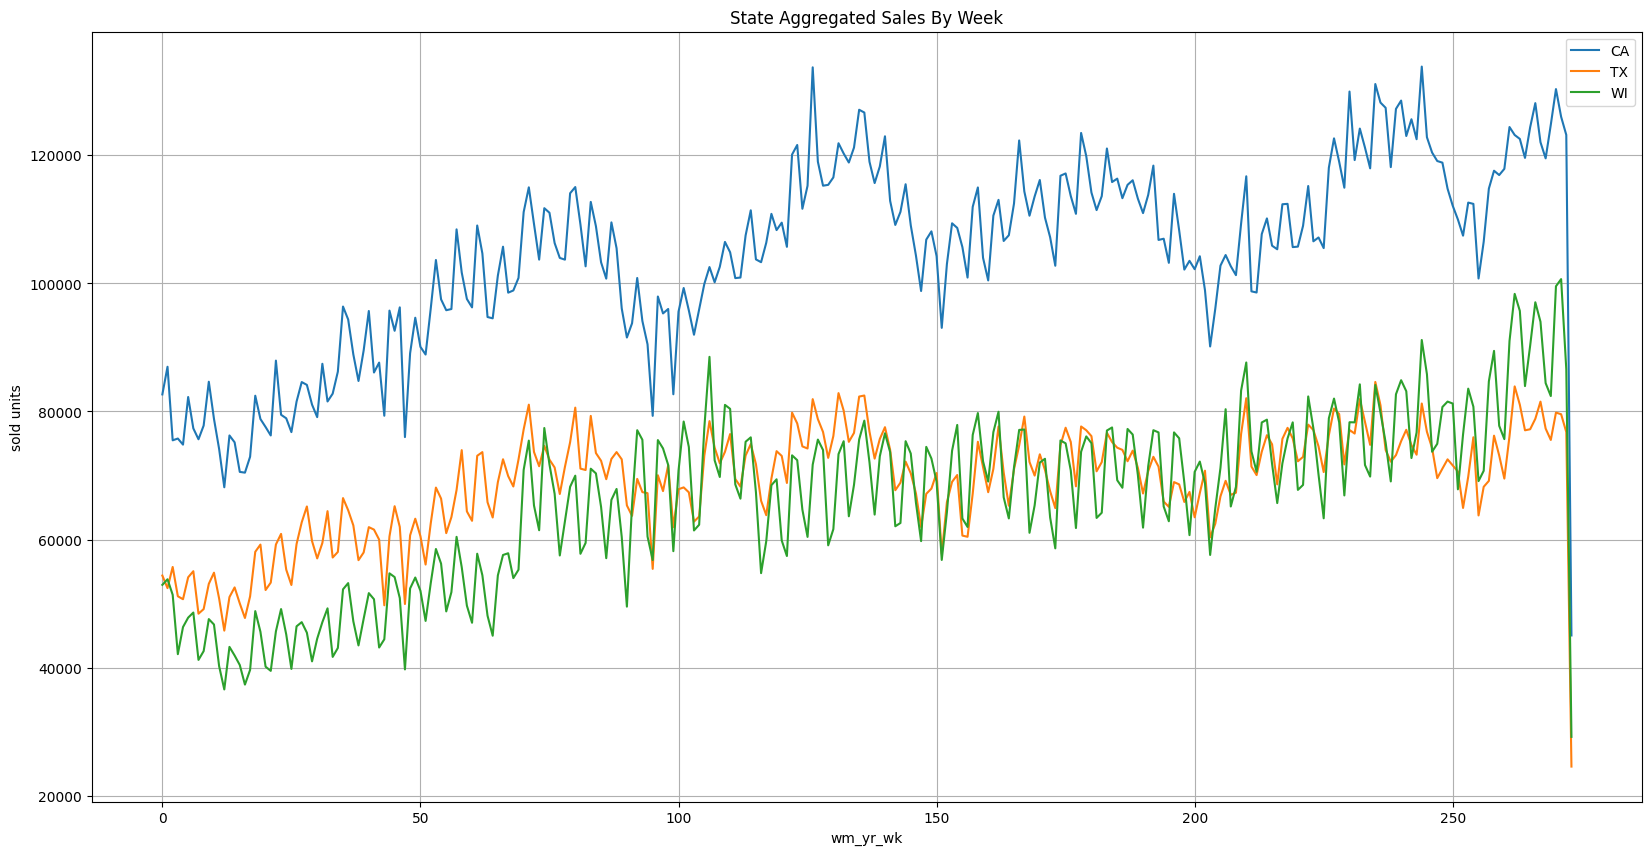

In [22]:
sales_by_store_and_date = df.groupby(["state_id", "wm_yr_wk"]).agg({"sold": np.sum, "date": "first"}).reset_index(drop=False)#["sold"].sum().reset_index(drop=False)
fig, axs = plt.subplots(1,1, figsize = (20,10))
for state in df.state_id.unique():
    axs.plot(sales_by_store_and_date[sales_by_store_and_date.state_id == state]["sold"].reset_index(drop=True), label = state)

axs.set_title("State Aggregated Sales By Week")
axs.set_xlabel("wm_yr_wk")
axs.set_ylabel("sold units")
axs.legend()
axs.grid()
plt.show()

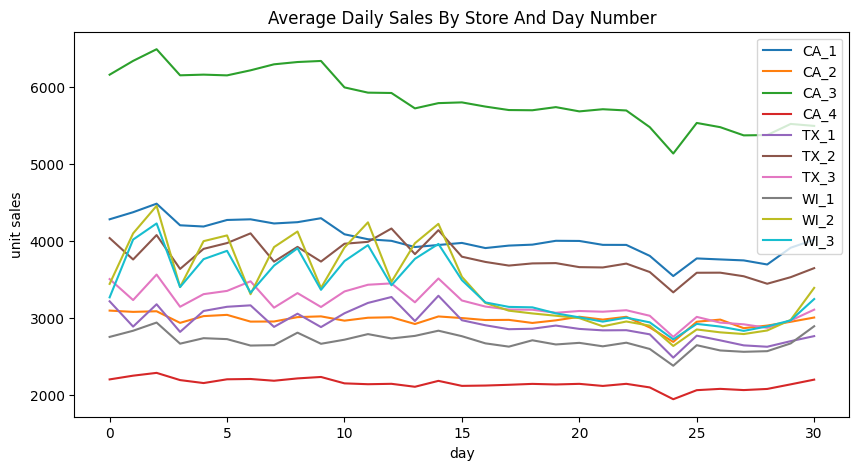

In [34]:
df_c = df.copy()
df_c["day"] = df_c.date.dt.day
sales_aggregated_by_day = df_c.groupby(["store_id", "d"]).agg({"sold": np.sum, "day": "last"}).reset_index(drop=False)
sales_by_store_and_date = sales_aggregated_by_day.groupby(["store_id", "day"]).agg({"sold": np.mean}).reset_index(drop=False)

fig, axs = plt.subplots(1,1, figsize = (10, 5))
for store in sales_by_store_and_date.store_id.unique():
    sales_by_store_and_date[sales_by_store_and_date.store_id == store].sold.reset_index(drop=True).plot(ax = axs, label = store)

axs.set_title("Average Daily Sales By Store And Day Number")
axs.set_xlabel("day")
axs.set_ylabel("unit sales")
axs.legend()
plt.show()

2023-07-25 21:29:28 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-25 21:29:28 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


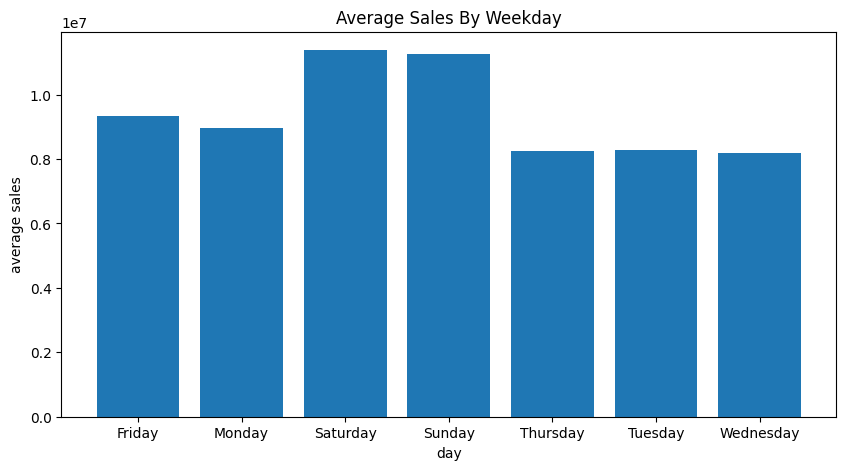

In [52]:
# average over all stores
sales_by_weekday = df.groupby(["weekday"]).agg({"sold": np.sum}).reset_index(drop=False)
fig, axs = plt.subplots(1,1, figsize = (10, 5))
axs.bar(sales_by_weekday.weekday, sales_by_weekday.sold)

axs.set_title("Average Sales By Weekday")
axs.set_xlabel("day")
axs.set_ylabel("average sales")
plt.show()

2023-07-26 13:21:30 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 13:21:30 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 13:21:30 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 13:21:30 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2023-07-26 13:21:30 - matplotlib.cat

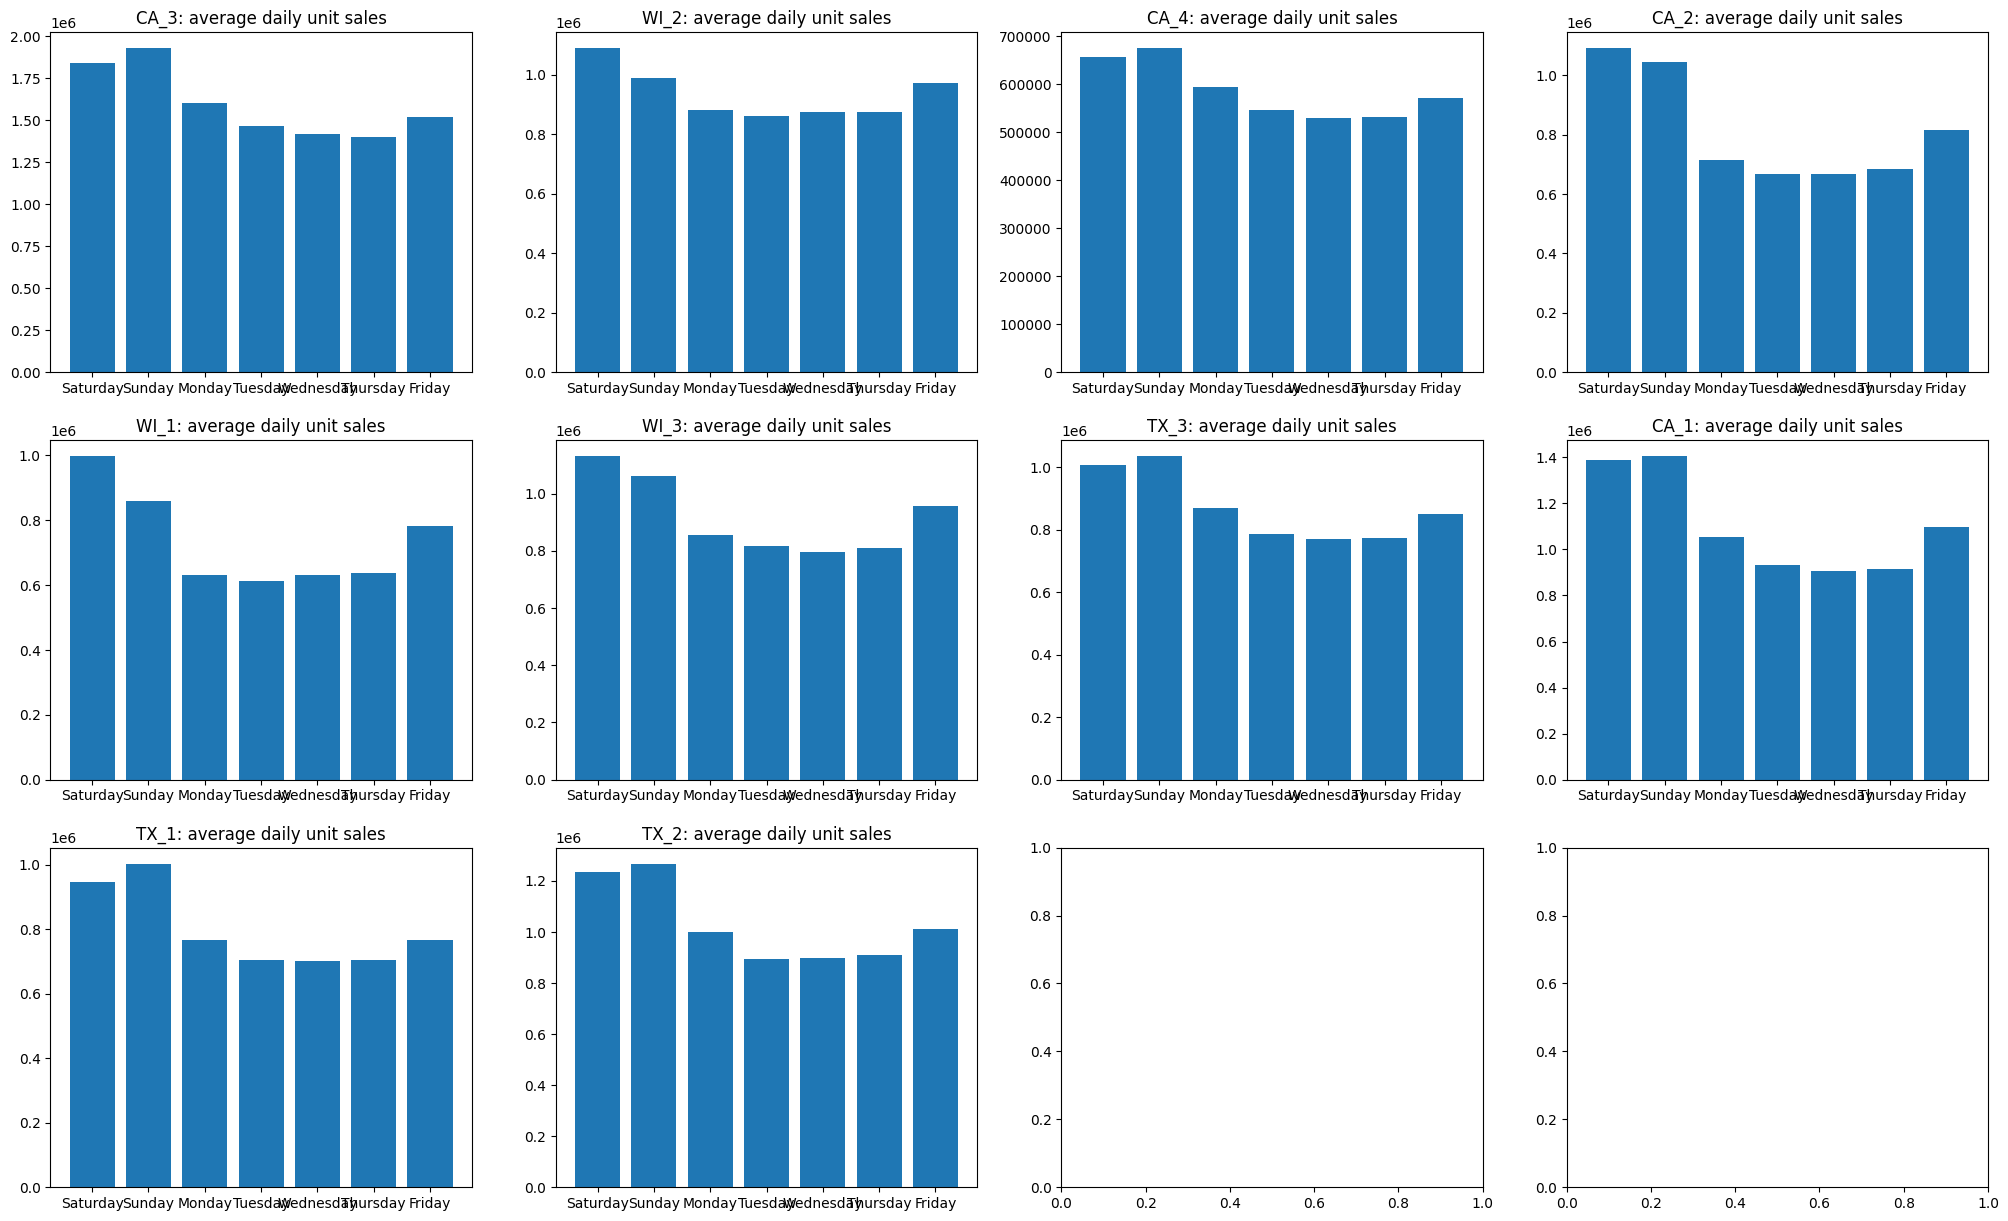

In [36]:
# grouped by store as well
sales_by_weekday = df.groupby(["store_id", "weekday"]).agg({"sold": np.sum, "wday": "last"}).reset_index(drop=False).sort_values(by="wday", ascending = True)
n_stores = sales_by_weekday["store_id"].nunique()

m = 4
n =  n_stores // m if n_stores % m == 0 else n_stores // m + 1
fig, axs = plt.subplots(n,m, figsize = (25, 15))

for k, store_id in enumerate(sales_by_weekday["store_id"].unique()):
    ax = axs[k // m, k % m]
    ax.bar(sales_by_weekday[sales_by_weekday["store_id"] == store_id].weekday, sales_by_weekday[sales_by_weekday["store_id"] == store_id].sold)
    ax.set_title(f"{store_id}: average daily unit sales")
plt.show()

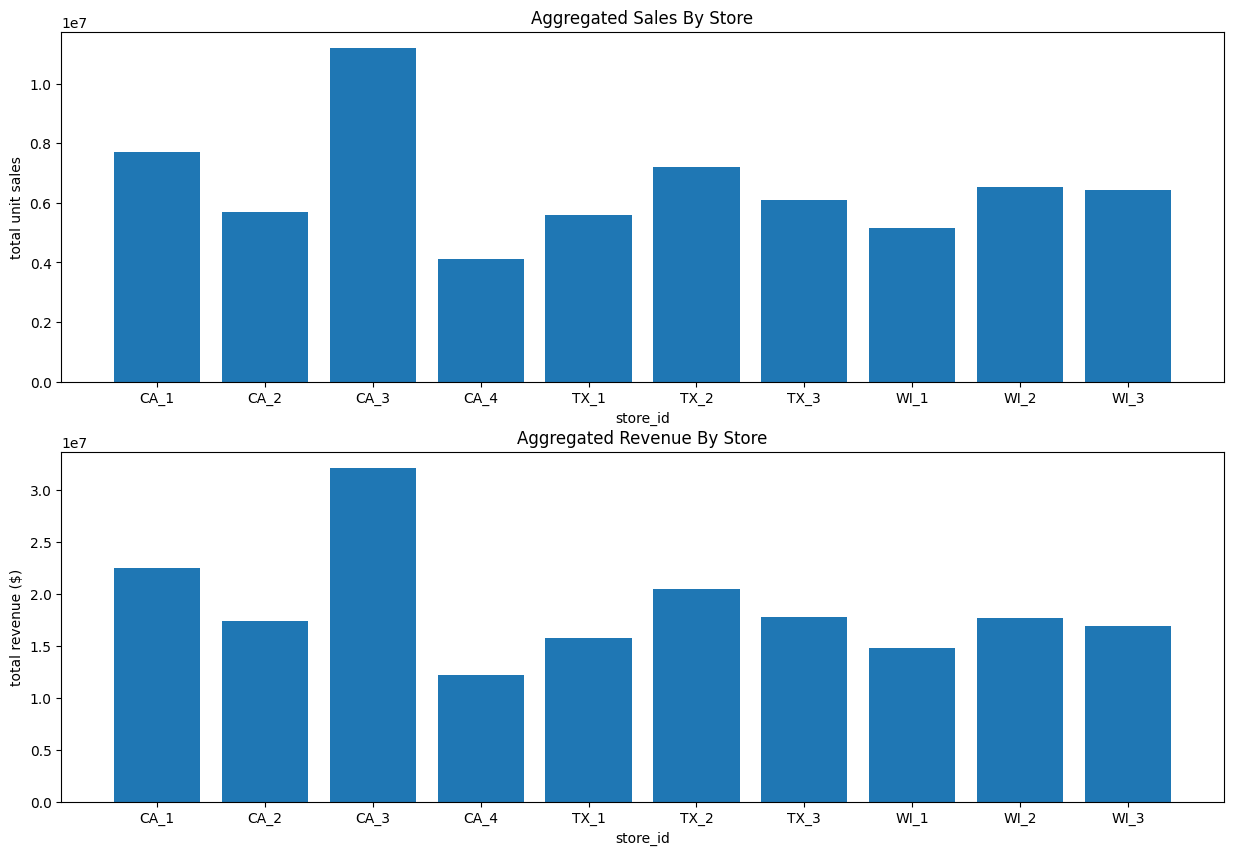

In [37]:
# grouped by store as well
sales_by_store_id = df.groupby(["store_id"]).agg({"sold": np.sum}).reset_index(drop=False)
n_stores = sales_by_store_id["store_id"].nunique()

fig, axs = plt.subplots(2,1, figsize = (15,10))
ax = axs[0]
ax.bar(sales_by_store_id.store_id, sales_by_store_id.sold)
ax.set_title("Aggregated Sales By Store")
ax.set_xlabel("store_id")
ax.set_ylabel("total unit sales")

df_c = df.copy()
df_c["sell_price"] = df_c["sell_price"].fillna(0)
df_c["revenue"] = df_c["sold"] * df_c["sell_price"]
sales_by_store_id = df_c.groupby(["store_id"]).agg({"revenue": np.sum}).reset_index(drop=False)
n_stores = sales_by_store_id["store_id"].nunique()

ax = axs[1]
ax.bar(sales_by_store_id.store_id, sales_by_store_id.revenue)
ax.set_title("Aggregated Revenue By Store")
ax.set_xlabel("store_id")
ax.set_ylabel("total revenue ($)")
plt.show()

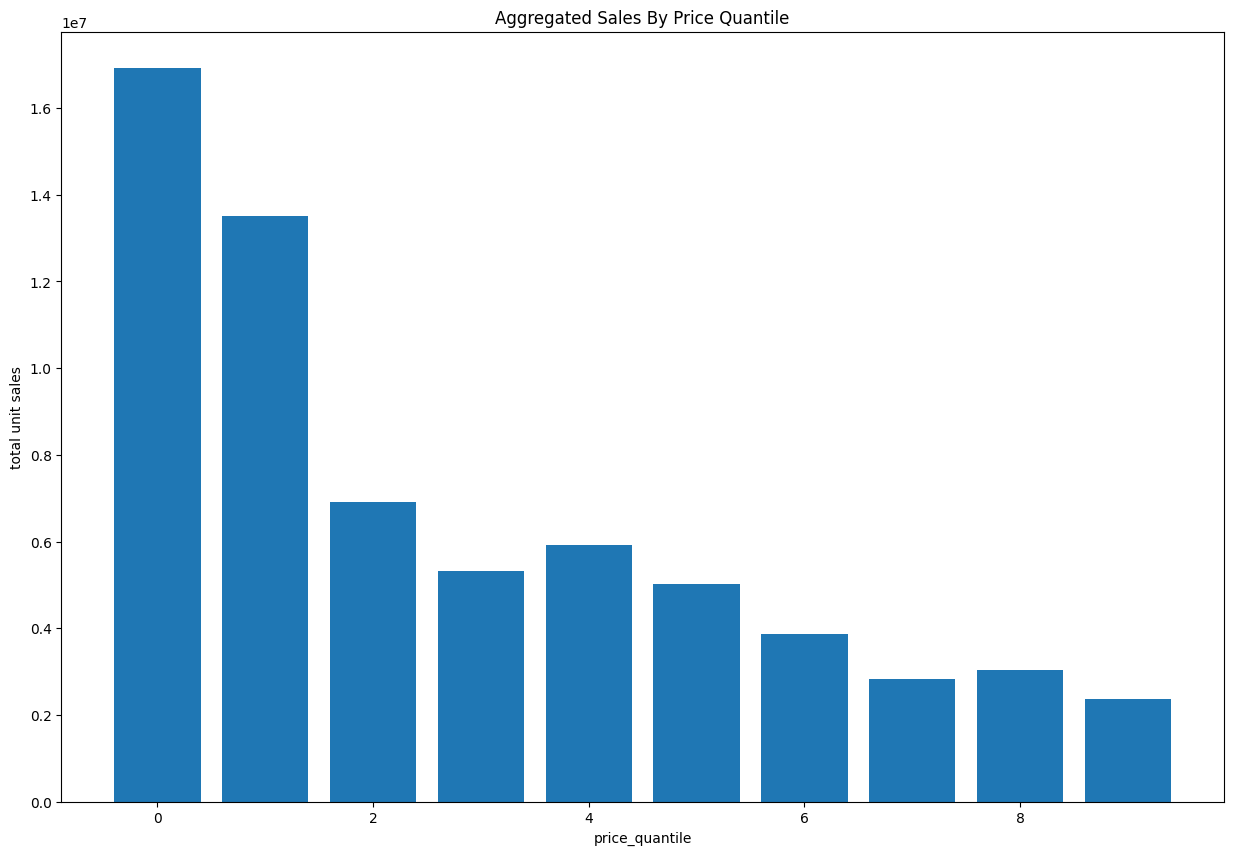

In [38]:
df["price_quantile"] = pd.qcut(df["sell_price"], 10, labels=False)
sales_by_price_quantile = df.groupby("price_quantile").agg({"sold": np.sum}).reset_index(drop=False)#.sort_values("price_quantile", ascending=True)

fig, ax = plt.subplots(1,1, figsize = (15,10))
ax.bar(sales_by_price_quantile.price_quantile, sales_by_price_quantile.sold)
ax.set_title("Aggregated Sales By Price Quantile")
ax.set_xlabel("price_quantile")
ax.set_ylabel("total unit sales")
plt.show()

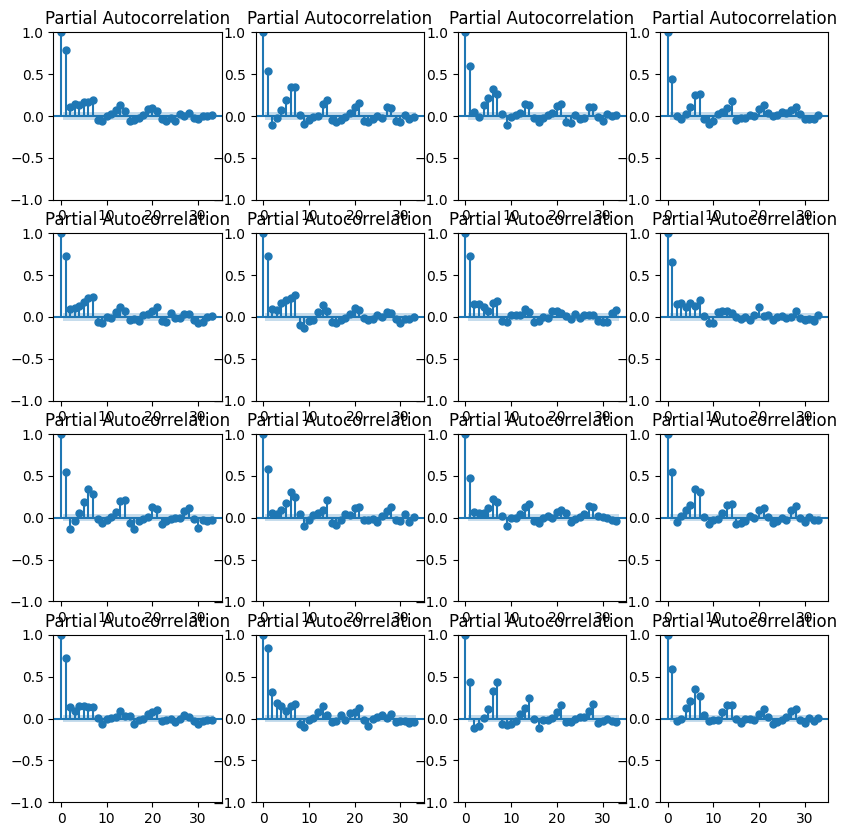

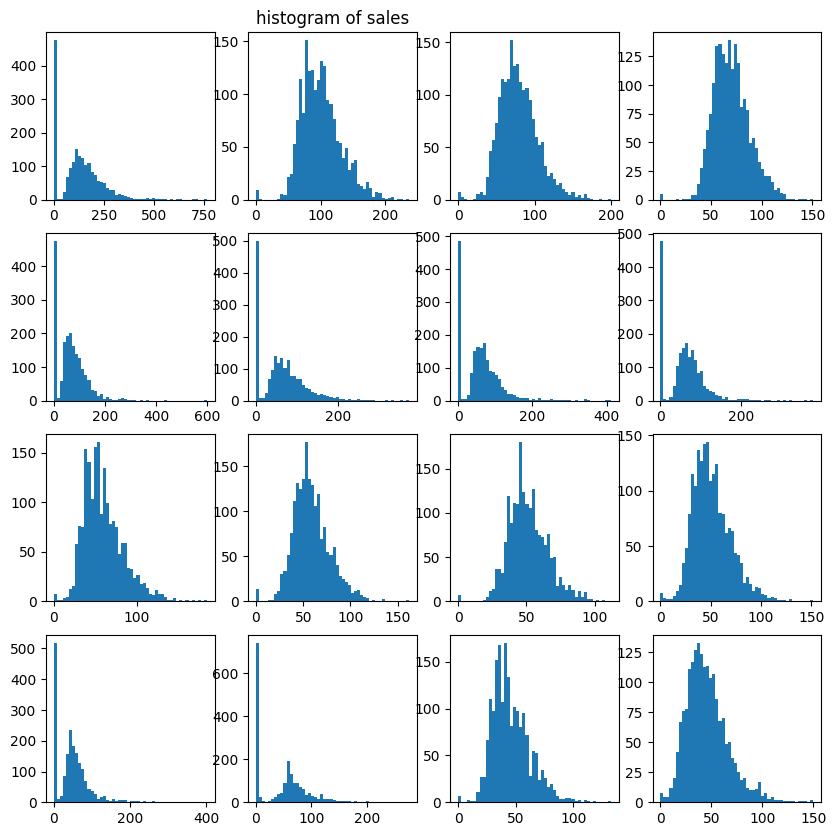

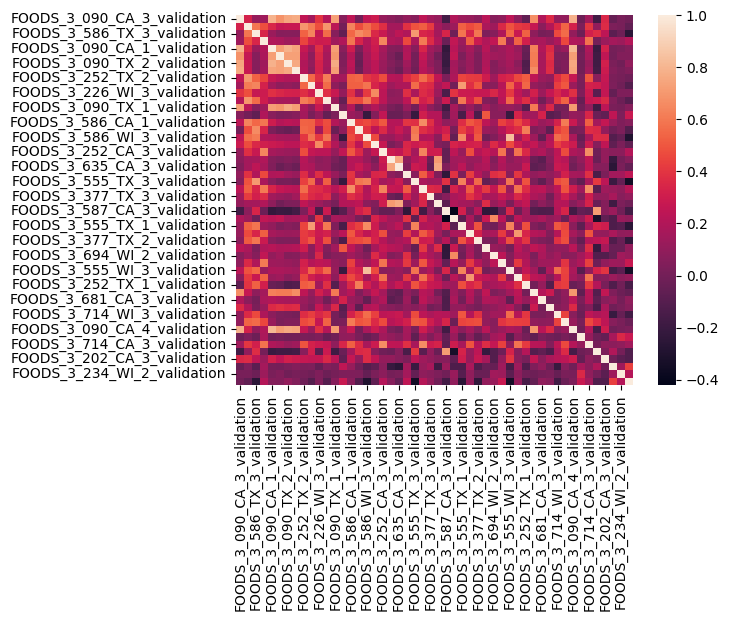

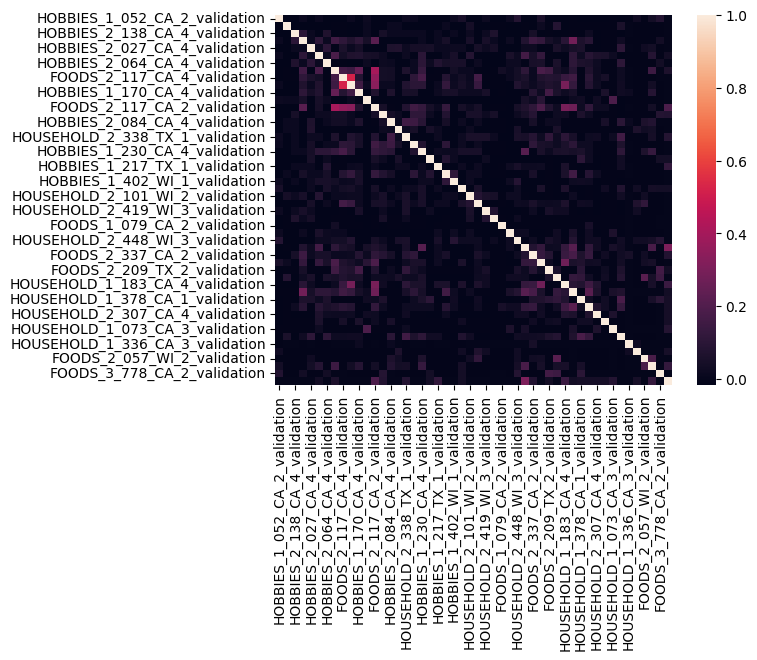

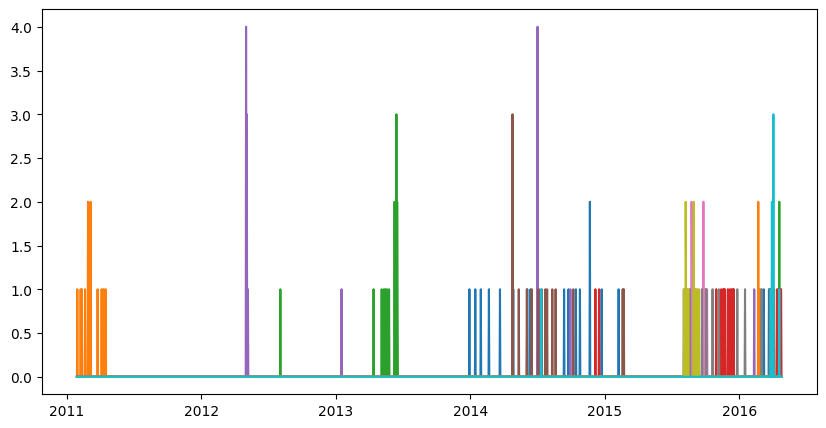

In [39]:
n = 4
m = 4
fig, axs = plt.subplots(n, m, figsize = (10,10))
for k in range(int(n*m)):
    ax = axs[k // n, k % m]
    plot_pacf(df[df["id"] == res.index[k]]["sold"].dropna(), ax = ax)
plt.show()

n = 4
m = 4
fig, axs = plt.subplots(n, m, figsize = (10,10))
for k in range(int(n*m)):
    ax = axs[k // n, k % m]
    ax.hist(df[df["id"] == res.index[k]]["sold"].dropna(), bins = 50)
axs[0,1].set_title("histogram of sales")
plt.show()

n = 50
sns.heatmap(pd.DataFrame(dict(zip(
    res.index[:n], 
    [
        df[df["id"] == id]["sold"].dropna().values 
        for id in res.index[:n]
    ]
))).corr())
plt.show()

n = 50
sns.heatmap(pd.DataFrame(dict(zip(
    res.index[-n:], 
    [
        df[df["id"] == id]["sold"].dropna().values 
        for id in res.index[-n:]
    ]
))).corr())
plt.show()

fig, axs = plt.subplots(1,1, figsize = (10,5))
for id in res.index[-10:]:
    axs.plot(df[df["id"] == id]["date"], df[df["id"] == id]["sold"])
plt.show()

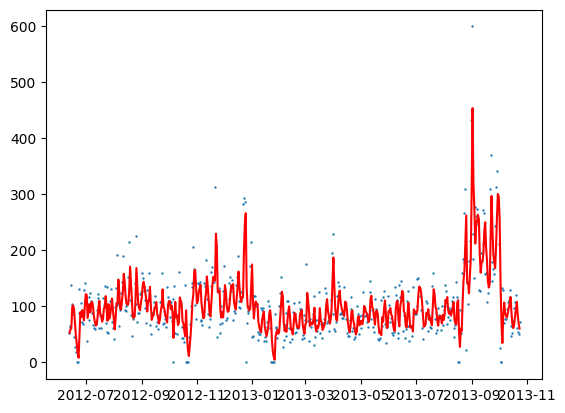

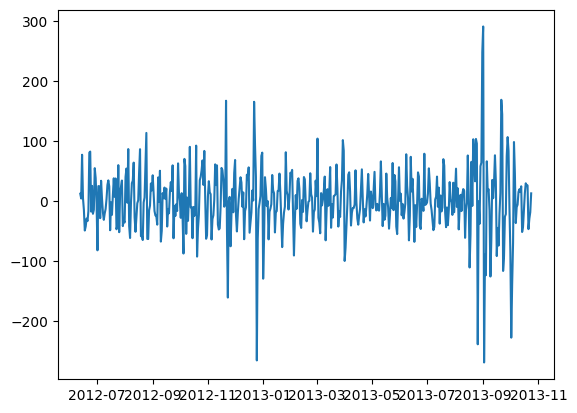

0.5 53.45372868432225


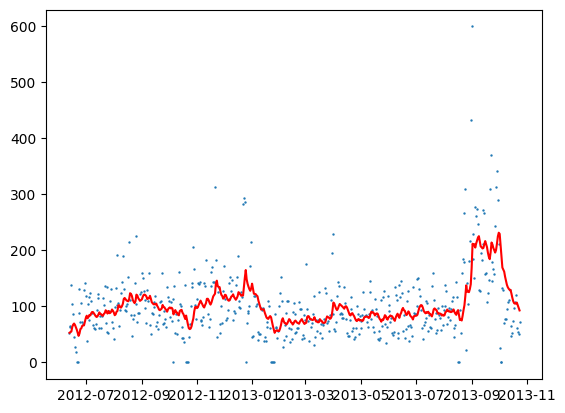

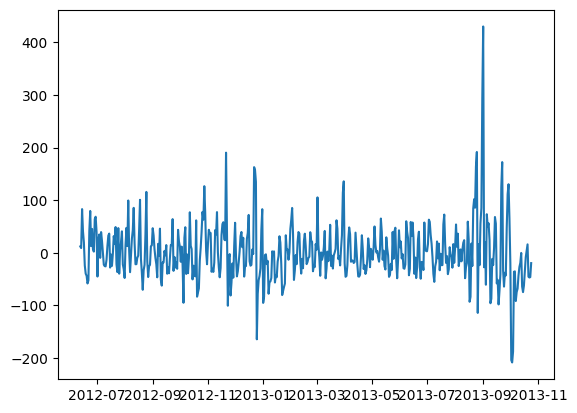

0.1 54.65090172672083


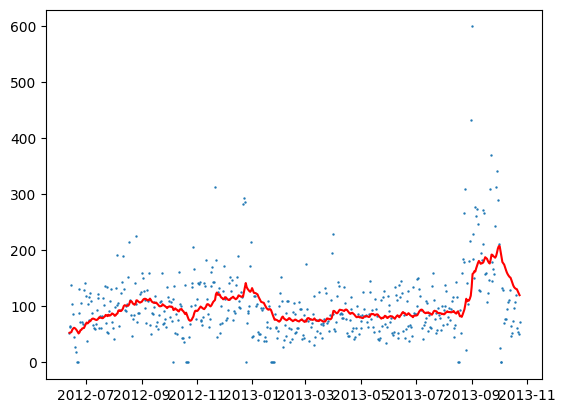

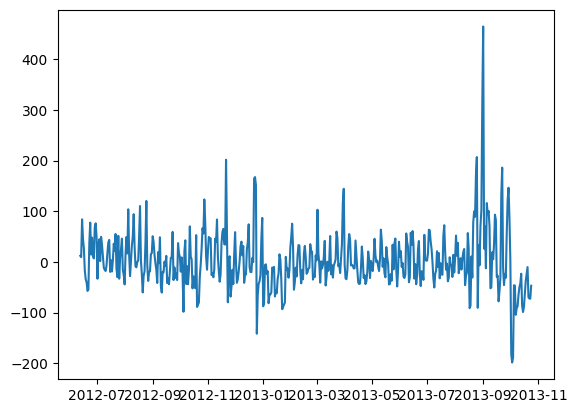

0.05 56.89258387012987


In [76]:
z = "FOODS_3_090_CA_1_validation"
x = df[df["id"] == z]["date"].iloc[500:1000]
y = df[df["id"] == z]["sold"].iloc[500:1000]

for alpha in [.5, .1, .05]:
    y_pred = y.ewm(alpha = alpha, adjust=False).mean().shift(1)
    plt.scatter(x, y, s=.5)
    plt.plot(x, y_pred, "r")
    plt.show()
    plt.plot(x, y - y_pred)
    plt.show()
    print(alpha, np.std(y - y_pred))

###

<Axes: >

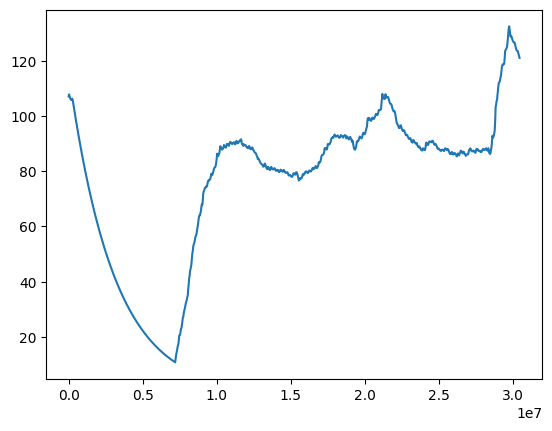

In [55]:
y.ewm(alpha=.01, adjust=False).mean().plot()